<a href="https://colab.research.google.com/github/alexjercan/normals-estimation/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib==3.3.3 albumentations==0.5.2

     |████████████████████████████████| 11.6MB 204kB/s 
     |████████████████████████████████| 81kB 11.6MB/s 
     |████████████████████████████████| 952kB 45.3MB/s 
     |████████████████████████████████| 38.2MB 75kB/s 
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [1]:
!git clone https://github.com/alexjercan/normals-estimation.git
%cd normals-estimation

import torch
from IPython.display import clear_output

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.1+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
# Download pretrained model
torch.hub.download_url_to_file('https://github.com/alexjercan/normals-estimation/releases/download/v1.0/normal.pth', 'normal.pth')

In [2]:
# Download dataset stereo
!bash ./get_bdataset.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   3961      0 --:--:-- --:--:-- --:--:--  3961
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1279M    0 1279M    0     0  72.1M      0 --:--:--  0:00:17 --:--:-- 90.7M
Completed in 39 seconds


In [16]:
!git pull
!python dataset.py
!python model.py

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/alexjercan/normals-estimation
   4dfeab2..6a2c4d8  master     -> origin/master
Updating 4dfeab2..6a2c4d8
Fast-forward
 model.py | 13 ++++++++-----
 1 file changed, 8 insertions(+), 5 deletions(-)
dataset ok
model ok


In [21]:
import os
import re
import cv2
import torch
import torch.optim
import albumentations as A
import my_albumentations as M

from datetime import datetime as dt
from albumentations.pytorch.transforms import ToTensorV2
from config import DEVICE
from model import Model, LossFunction
from general import init_weights, load_checkpoint, save_checkpoint
from dataset import create_dataloader
from metrics import MetricFunction, print_single_error
from detect import generatePredictions
from train import train_one_epoch
from test import run_test
from util import save_predictions, plot_predictions
from dataset import LoadImages

IMAGE_SIZE = 256
DATASET_ROOT = "../bdataset_stereo"
TRAIN_JSON_PATH = "train.json"
TEST_JSON_PATH = "test.json"
IMAGES = [
          {"imageL": "data/0000L.png", "imageR": "data/0000R.png", "output": "data/out/0000.exr"},
          {"imageL": "data/0001L.png", "imageR": "data/0001R.png", "output": "data/out/0001.exr"},
          {"imageL": "data/0002L.png", "imageR": "data/0002R.png", "output": "data/out/0002.exr"},
]
BATCH_SIZE = 8
WORKERS = 8

LEARNING_RATE = 1e-3
BETAS = [.9, .999]
EPS = 1e-8
WEIGHT_DECAY = 1e-5

MILESTONES = [10, 20, 30]
GAMMA = 0.2

NUM_EPOCHS = 40
OUT_PATH = "./runs"
LOAD_TRAIN_MODEL = False
LOAD_TEST_MODEL = False
CHECKPOINT_TRAIN_FILE = "normal.pth"
CHECKPOINT_TEST_FILE = "normal.pth"

torch.backends.cudnn.benchmark = True

In [6]:
train_transform = A.Compose(
    [
        M.MyRandomResizedCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.OneOf([
            M.MyOpticalDistortion(p=0.3),
            M.MyGridDistortion(p=0.1),
        ], p=0.2),
        A.OneOf([
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.Normalize(),
        M.MyToTensorV2(),
    ],
    additional_targets={
        'right_img': 'image',
        'left_normal': 'normal',
        'right_normal': 'normal',
    }
)

test_transform = A.Compose(
    [
        A.Normalize(),
        M.MyToTensorV2(),
    ],
    additional_targets={
        'right_img': 'image',
        'left_normal': 'normal',
        'right_normal': 'normal',
    }
)

detect_transform = A.Compose(
    [
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        A.PadIfNeeded(min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.Normalize(),
        M.MyToTensorV2(),
    ],
    additional_targets={
        'right_img': 'image',
    }
)

_, train_dataloader = create_dataloader(DATASET_ROOT, TRAIN_JSON_PATH, 
                                        batch_size=BATCH_SIZE, transform=train_transform, 
                                        workers=WORKERS, pin_memory=True, shuffle=True)

_, test_dataloader = create_dataloader(DATASET_ROOT, TEST_JSON_PATH,
                                       batch_size=BATCH_SIZE, transform=test_transform,
                                       workers=WORKERS, pin_memory=True, shuffle=False)


In [7]:
model = Model()
model.apply(init_weights)
solver = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                          lr=LEARNING_RATE, betas=BETAS, 
                          eps=EPS, weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(solver, milestones=MILESTONES, gamma=GAMMA)
model = model.to(DEVICE)
loss_fn = LossFunction()

In [8]:
epoch_idx = 0
if LOAD_TRAIN_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_TRAIN_FILE, DEVICE)

model.train()
for epoch_idx in range(epoch_idx, NUM_EPOCHS):
    metric_fn = MetricFunction(BATCH_SIZE)
    train_one_epoch(model, train_dataloader, loss_fn, metric_fn, solver, epoch_idx)
    print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())
    lr_scheduler.step()


  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 0, loss=(total:1.0628 l1:0.18745388090610504 1-cos:0.8753789663314819)
======NORMALS=======
MSE=2.4956	RMSE=1.5792	MAE=1.5210	MME=1.5708
TANGLE11.25=0.0063	TANGLE22.5=0.0237	TANGLE30.0=0.0391



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 1, loss=(total:1.1305 l1:0.1952430158853531 1-cos:0.935261607170105)
======NORMALS=======
MSE=2.4415	RMSE=1.5619	MAE=1.4983	MME=1.5708
TANGLE11.25=0.0081	TANGLE22.5=0.0320	TANGLE30.0=0.0520



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 2, loss=(total:1.1229 l1:0.3416517674922943 1-cos:0.7812175154685974)
======NORMALS=======
MSE=2.3514	RMSE=1.5326	MAE=1.4648	MME=1.5708
TANGLE11.25=0.0100	TANGLE22.5=0.0404	TANGLE30.0=0.0638



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 3, loss=(total:1.4032 l1:0.31667661666870117 1-cos:1.086493730545044)
======NORMALS=======
MSE=2.2885	RMSE=1.5119	MAE=1.4408	MME=1.5708
TANGLE11.25=0.0136	TANGLE22.5=0.0491	TANGLE30.0=0.0772



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 4, loss=(total:1.1242 l1:0.21416397392749786 1-cos:0.9100582003593445)
======NORMALS=======
MSE=2.2498	RMSE=1.4989	MAE=1.4246	MME=1.5708
TANGLE11.25=0.0179	TANGLE22.5=0.0551	TANGLE30.0=0.0839



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 5, loss=(total:0.9803 l1:0.14491818845272064 1-cos:0.8353630900382996)
======NORMALS=======
MSE=2.2099	RMSE=1.4855	MAE=1.4102	MME=1.5708
TANGLE11.25=0.0224	TANGLE22.5=0.0618	TANGLE30.0=0.0886



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 6, loss=(total:1.0995 l1:0.15544721484184265 1-cos:0.944044291973114)
======NORMALS=======
MSE=2.1997	RMSE=1.4820	MAE=1.4053	MME=1.5705
TANGLE11.25=0.0242	TANGLE22.5=0.0629	TANGLE30.0=0.0917



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 7, loss=(total:0.8400 l1:0.1854536086320877 1-cos:0.6545605063438416)
======NORMALS=======
MSE=2.2074	RMSE=1.4845	MAE=1.4075	MME=1.5708
TANGLE11.25=0.0245	TANGLE22.5=0.0619	TANGLE30.0=0.0890



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 8, loss=(total:0.9873 l1:0.10551746189594269 1-cos:0.8817542791366577)
======NORMALS=======
MSE=2.1794	RMSE=1.4753	MAE=1.3956	MME=1.5708
TANGLE11.25=0.0308	TANGLE22.5=0.0674	TANGLE30.0=0.0949



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 9, loss=(total:1.0071 l1:0.08471580594778061 1-cos:0.9223450422286987)
======NORMALS=======
MSE=2.1822	RMSE=1.4762	MAE=1.3985	MME=1.5708
TANGLE11.25=0.0251	TANGLE22.5=0.0650	TANGLE30.0=0.0945



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 10, loss=(total:1.0212 l1:0.12840133905410767 1-cos:0.8928136825561523)
======NORMALS=======
MSE=2.1673	RMSE=1.4711	MAE=1.3907	MME=1.5708
TANGLE11.25=0.0291	TANGLE22.5=0.0695	TANGLE30.0=0.0985



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 11, loss=(total:0.8262 l1:0.14041297137737274 1-cos:0.6858009099960327)
======NORMALS=======
MSE=2.1373	RMSE=1.4608	MAE=1.3781	MME=1.5708
TANGLE11.25=0.0327	TANGLE22.5=0.0751	TANGLE30.0=0.1049



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 12, loss=(total:1.0997 l1:0.13345202803611755 1-cos:0.9662351012229919)
======NORMALS=======
MSE=2.1477	RMSE=1.4644	MAE=1.3817	MME=1.5708
TANGLE11.25=0.0339	TANGLE22.5=0.0750	TANGLE30.0=0.1039



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 13, loss=(total:1.0592 l1:0.1157446876168251 1-cos:0.9434727430343628)
======NORMALS=======
MSE=2.1282	RMSE=1.4577	MAE=1.3742	MME=1.5708
TANGLE11.25=0.0342	TANGLE22.5=0.0778	TANGLE30.0=0.1077



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 14, loss=(total:1.0689 l1:0.16583877801895142 1-cos:0.903049647808075)
======NORMALS=======
MSE=2.1337	RMSE=1.4596	MAE=1.3762	MME=1.5708
TANGLE11.25=0.0331	TANGLE22.5=0.0752	TANGLE30.0=0.1064



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 15, loss=(total:1.0516 l1:0.14880318939685822 1-cos:0.9027737379074097)
======NORMALS=======
MSE=2.1179	RMSE=1.4541	MAE=1.3714	MME=1.5708
TANGLE11.25=0.0304	TANGLE22.5=0.0755	TANGLE30.0=0.1081



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 16, loss=(total:0.8610 l1:0.1845875084400177 1-cos:0.6764556765556335)
======NORMALS=======
MSE=2.1009	RMSE=1.4485	MAE=1.3633	MME=1.5708
TANGLE11.25=0.0332	TANGLE22.5=0.0797	TANGLE30.0=0.1120



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 17, loss=(total:1.0731 l1:0.16174428164958954 1-cos:0.9113163352012634)
======NORMALS=======
MSE=2.1281	RMSE=1.4576	MAE=1.3745	MME=1.5708
TANGLE11.25=0.0304	TANGLE22.5=0.0760	TANGLE30.0=0.1069



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 18, loss=(total:0.9911 l1:0.0937267318367958 1-cos:0.897386908531189)
======NORMALS=======
MSE=2.1205	RMSE=1.4547	MAE=1.3705	MME=1.5707
TANGLE11.25=0.0318	TANGLE22.5=0.0768	TANGLE30.0=0.1084



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 19, loss=(total:0.9389 l1:0.1542195826768875 1-cos:0.7846904993057251)
======NORMALS=======
MSE=2.0992	RMSE=1.4478	MAE=1.3639	MME=1.5708
TANGLE11.25=0.0313	TANGLE22.5=0.0778	TANGLE30.0=0.1105



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 20, loss=(total:0.9691 l1:0.10810846090316772 1-cos:0.8609656095504761)
======NORMALS=======
MSE=2.0763	RMSE=1.4398	MAE=1.3549	MME=1.5708
TANGLE11.25=0.0335	TANGLE22.5=0.0821	TANGLE30.0=0.1153



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 21, loss=(total:0.9549 l1:0.13035446405410767 1-cos:0.8245776891708374)
======NORMALS=======
MSE=2.0838	RMSE=1.4423	MAE=1.3575	MME=1.5708
TANGLE11.25=0.0322	TANGLE22.5=0.0816	TANGLE30.0=0.1146



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 22, loss=(total:1.0230 l1:0.2494032382965088 1-cos:0.7735854983329773)
======NORMALS=======
MSE=2.0757	RMSE=1.4396	MAE=1.3551	MME=1.5708
TANGLE11.25=0.0326	TANGLE22.5=0.0821	TANGLE30.0=0.1154



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 23, loss=(total:0.9631 l1:0.06166344881057739 1-cos:0.9014543294906616)
======NORMALS=======
MSE=2.0749	RMSE=1.4394	MAE=1.3536	MME=1.5708
TANGLE11.25=0.0333	TANGLE22.5=0.0844	TANGLE30.0=0.1172



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 24, loss=(total:1.0722 l1:0.18665851652622223 1-cos:0.8855346441268921)
======NORMALS=======
MSE=2.0683	RMSE=1.4371	MAE=1.3504	MME=1.5708
TANGLE11.25=0.0332	TANGLE22.5=0.0855	TANGLE30.0=0.1187



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 25, loss=(total:0.9835 l1:0.07802841812372208 1-cos:0.9054986238479614)
======NORMALS=======
MSE=2.0709	RMSE=1.4381	MAE=1.3524	MME=1.5708
TANGLE11.25=0.0344	TANGLE22.5=0.0840	TANGLE30.0=0.1172



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 26, loss=(total:0.9542 l1:0.17191942036151886 1-cos:0.7822911143302917)
======NORMALS=======
MSE=2.0548	RMSE=1.4323	MAE=1.3457	MME=1.5701
TANGLE11.25=0.0335	TANGLE22.5=0.0863	TANGLE30.0=0.1207



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 27, loss=(total:0.9770 l1:0.14131532609462738 1-cos:0.8356698751449585)
======NORMALS=======
MSE=2.0652	RMSE=1.4359	MAE=1.3501	MME=1.5708
TANGLE11.25=0.0319	TANGLE22.5=0.0845	TANGLE30.0=0.1188



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 28, loss=(total:0.9625 l1:0.1476600617170334 1-cos:0.814873456954956)
======NORMALS=======
MSE=2.0605	RMSE=1.4345	MAE=1.3491	MME=1.5708
TANGLE11.25=0.0323	TANGLE22.5=0.0829	TANGLE30.0=0.1169



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 29, loss=(total:0.9640 l1:0.17174847424030304 1-cos:0.792231023311615)
======NORMALS=======
MSE=2.0591	RMSE=1.4338	MAE=1.3480	MME=1.5708
TANGLE11.25=0.0310	TANGLE22.5=0.0834	TANGLE30.0=0.1178



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 30, loss=(total:0.9255 l1:0.14838197827339172 1-cos:0.7771620154380798)
======NORMALS=======
MSE=2.0622	RMSE=1.4351	MAE=1.3489	MME=1.5708
TANGLE11.25=0.0327	TANGLE22.5=0.0848	TANGLE30.0=0.1180



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 31, loss=(total:0.9724 l1:0.13909456133842468 1-cos:0.8333309888839722)
======NORMALS=======
MSE=2.0533	RMSE=1.4318	MAE=1.3461	MME=1.5708
TANGLE11.25=0.0309	TANGLE22.5=0.0850	TANGLE30.0=0.1189



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 32, loss=(total:0.9663 l1:0.1347838044166565 1-cos:0.831521213054657)
======NORMALS=======
MSE=2.0530	RMSE=1.4317	MAE=1.3459	MME=1.5708
TANGLE11.25=0.0331	TANGLE22.5=0.0852	TANGLE30.0=0.1190



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 33, loss=(total:1.0437 l1:0.15828466415405273 1-cos:0.8854631185531616)
======NORMALS=======
MSE=2.0531	RMSE=1.4318	MAE=1.3460	MME=1.5708
TANGLE11.25=0.0327	TANGLE22.5=0.0850	TANGLE30.0=0.1193



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 34, loss=(total:0.9211 l1:0.11673188209533691 1-cos:0.8044064044952393)
======NORMALS=======
MSE=2.0531	RMSE=1.4319	MAE=1.3445	MME=1.5708
TANGLE11.25=0.0340	TANGLE22.5=0.0868	TANGLE30.0=0.1212



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 35, loss=(total:1.0306 l1:0.1106177419424057 1-cos:0.9199661612510681)
======NORMALS=======
MSE=2.0618	RMSE=1.4347	MAE=1.3496	MME=1.5708
TANGLE11.25=0.0326	TANGLE22.5=0.0842	TANGLE30.0=0.1180



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 36, loss=(total:0.8807 l1:0.1547965556383133 1-cos:0.7258629202842712)
======NORMALS=======
MSE=2.0482	RMSE=1.4301	MAE=1.3437	MME=1.5708
TANGLE11.25=0.0334	TANGLE22.5=0.0863	TANGLE30.0=0.1206



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 37, loss=(total:0.9494 l1:0.11298039555549622 1-cos:0.8363722562789917)
======NORMALS=======
MSE=2.0543	RMSE=1.4321	MAE=1.3460	MME=1.5708
TANGLE11.25=0.0342	TANGLE22.5=0.0857	TANGLE30.0=0.1196



  0%|          | 0/309 [00:00<?, ?it/s]

eval_avg_error
Epoch: 38, loss=(total:0.9343 l1:0.1136256605386734 1-cos:0.8206577301025391)
======NORMALS=======
MSE=2.0492	RMSE=1.4305	MAE=1.3451	MME=1.5708
TANGLE11.25=0.0326	TANGLE22.5=0.0851	TANGLE30.0=0.1189



100%|██████████| 309/309 [02:31<00:00,  2.04it/s, epoch=39, loss=(total:0.9794 l1:0.18823650479316711 1-cos:0.7911427021026611)]

eval_avg_error
Epoch: 39, loss=(total:0.9794 l1:0.18823650479316711 1-cos:0.7911427021026611)
======NORMALS=======
MSE=2.0424	RMSE=1.4279	MAE=1.3411	MME=1.5707
TANGLE11.25=0.0341	TANGLE22.5=0.0876	TANGLE30.0=0.1223



In [9]:
if LOAD_TEST_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_TEST_FILE, DEVICE)

model.eval()
metric_fn = MetricFunction(BATCH_SIZE)
run_test(model, test_dataloader, loss_fn, metric_fn)
print_single_error(epoch_idx, loss_fn.show(), metric_fn.show())

100%|██████████| 155/155 [00:27<00:00,  5.72it/s]

eval_avg_error
Epoch: 39, loss=(total:0.7971 l1:0.3615599572658539 1-cos:0.4355396628379822)
======NORMALS=======
MSE=2.0624	RMSE=1.4332	MAE=1.3626	MME=1.5578
TANGLE11.25=0.0259	TANGLE22.5=0.0725	TANGLE30.0=0.1048



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])


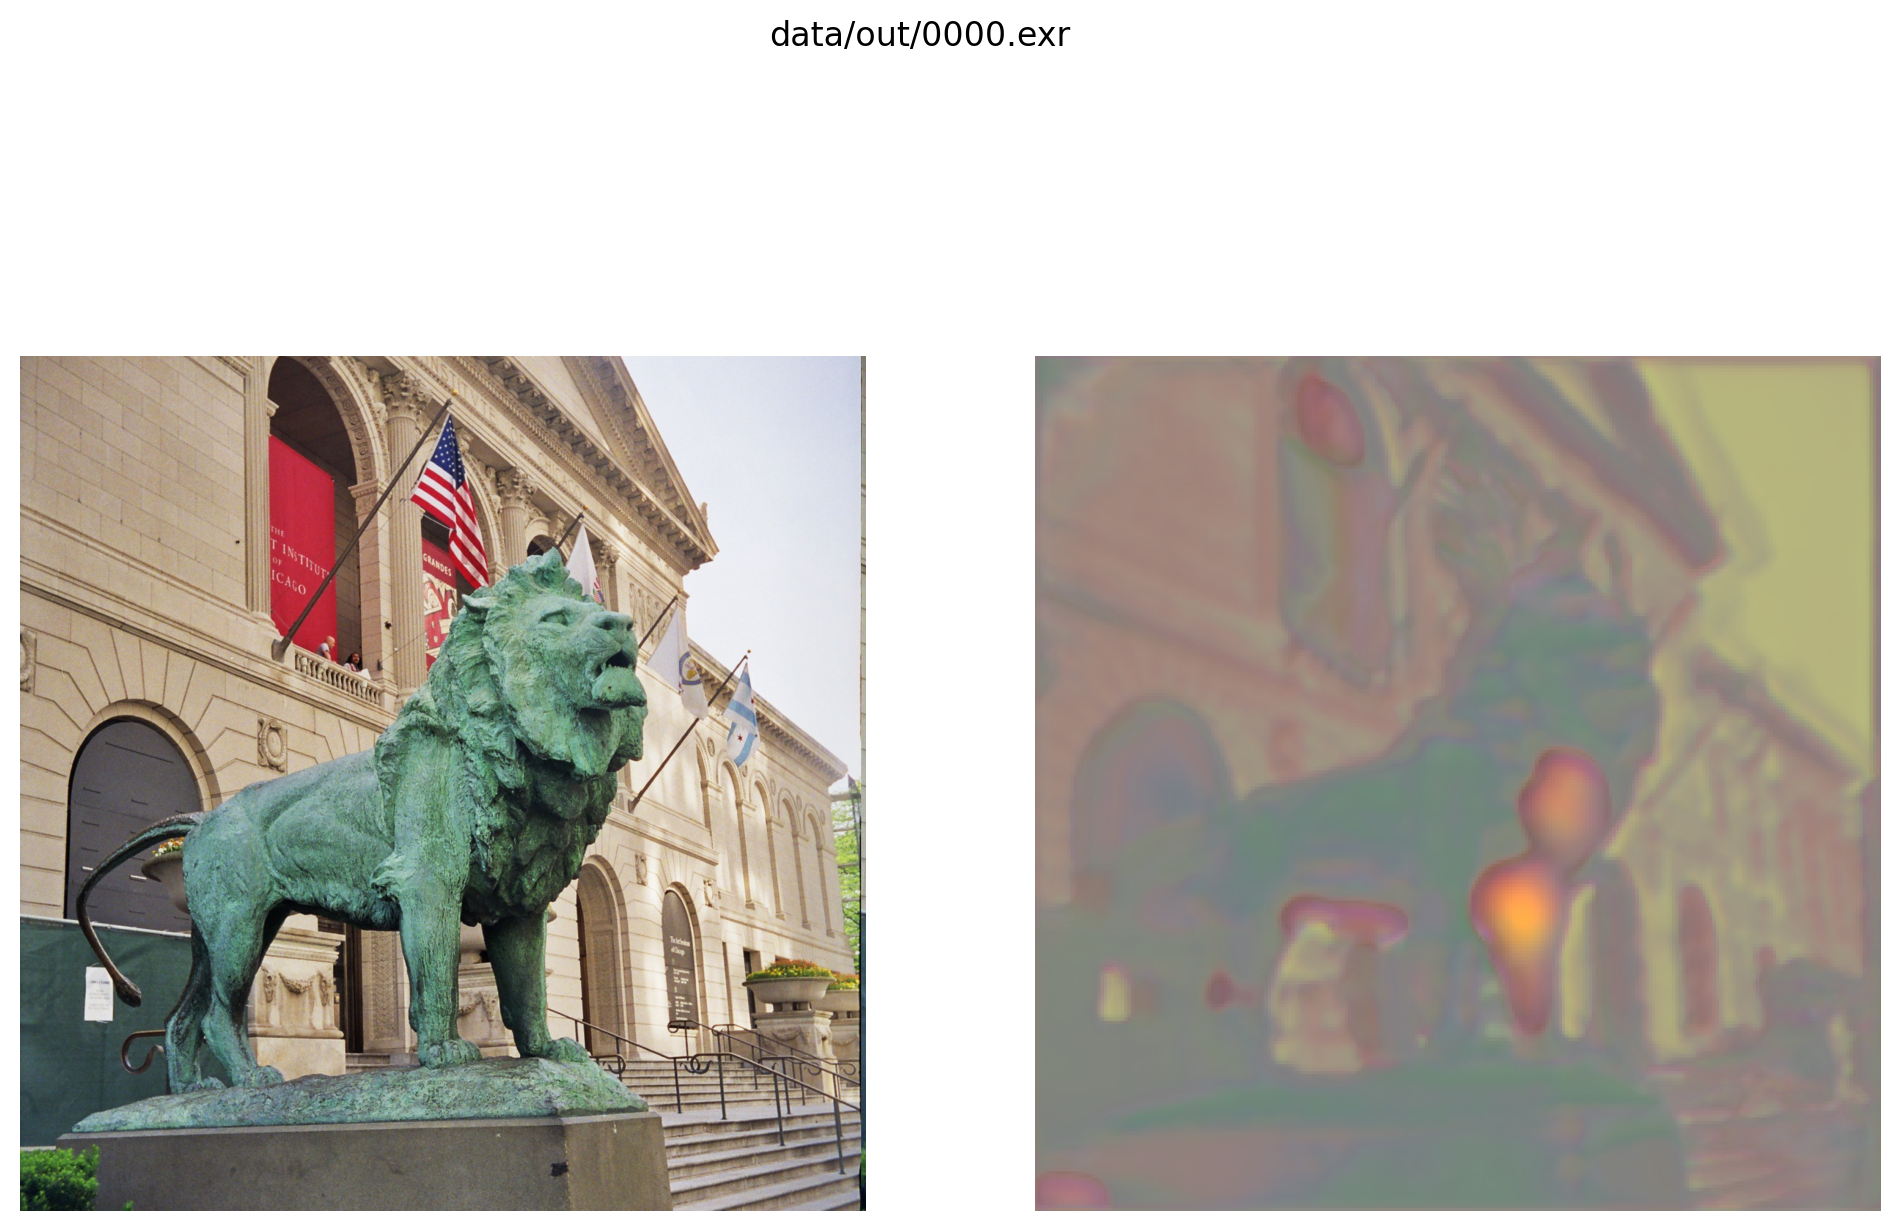

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])


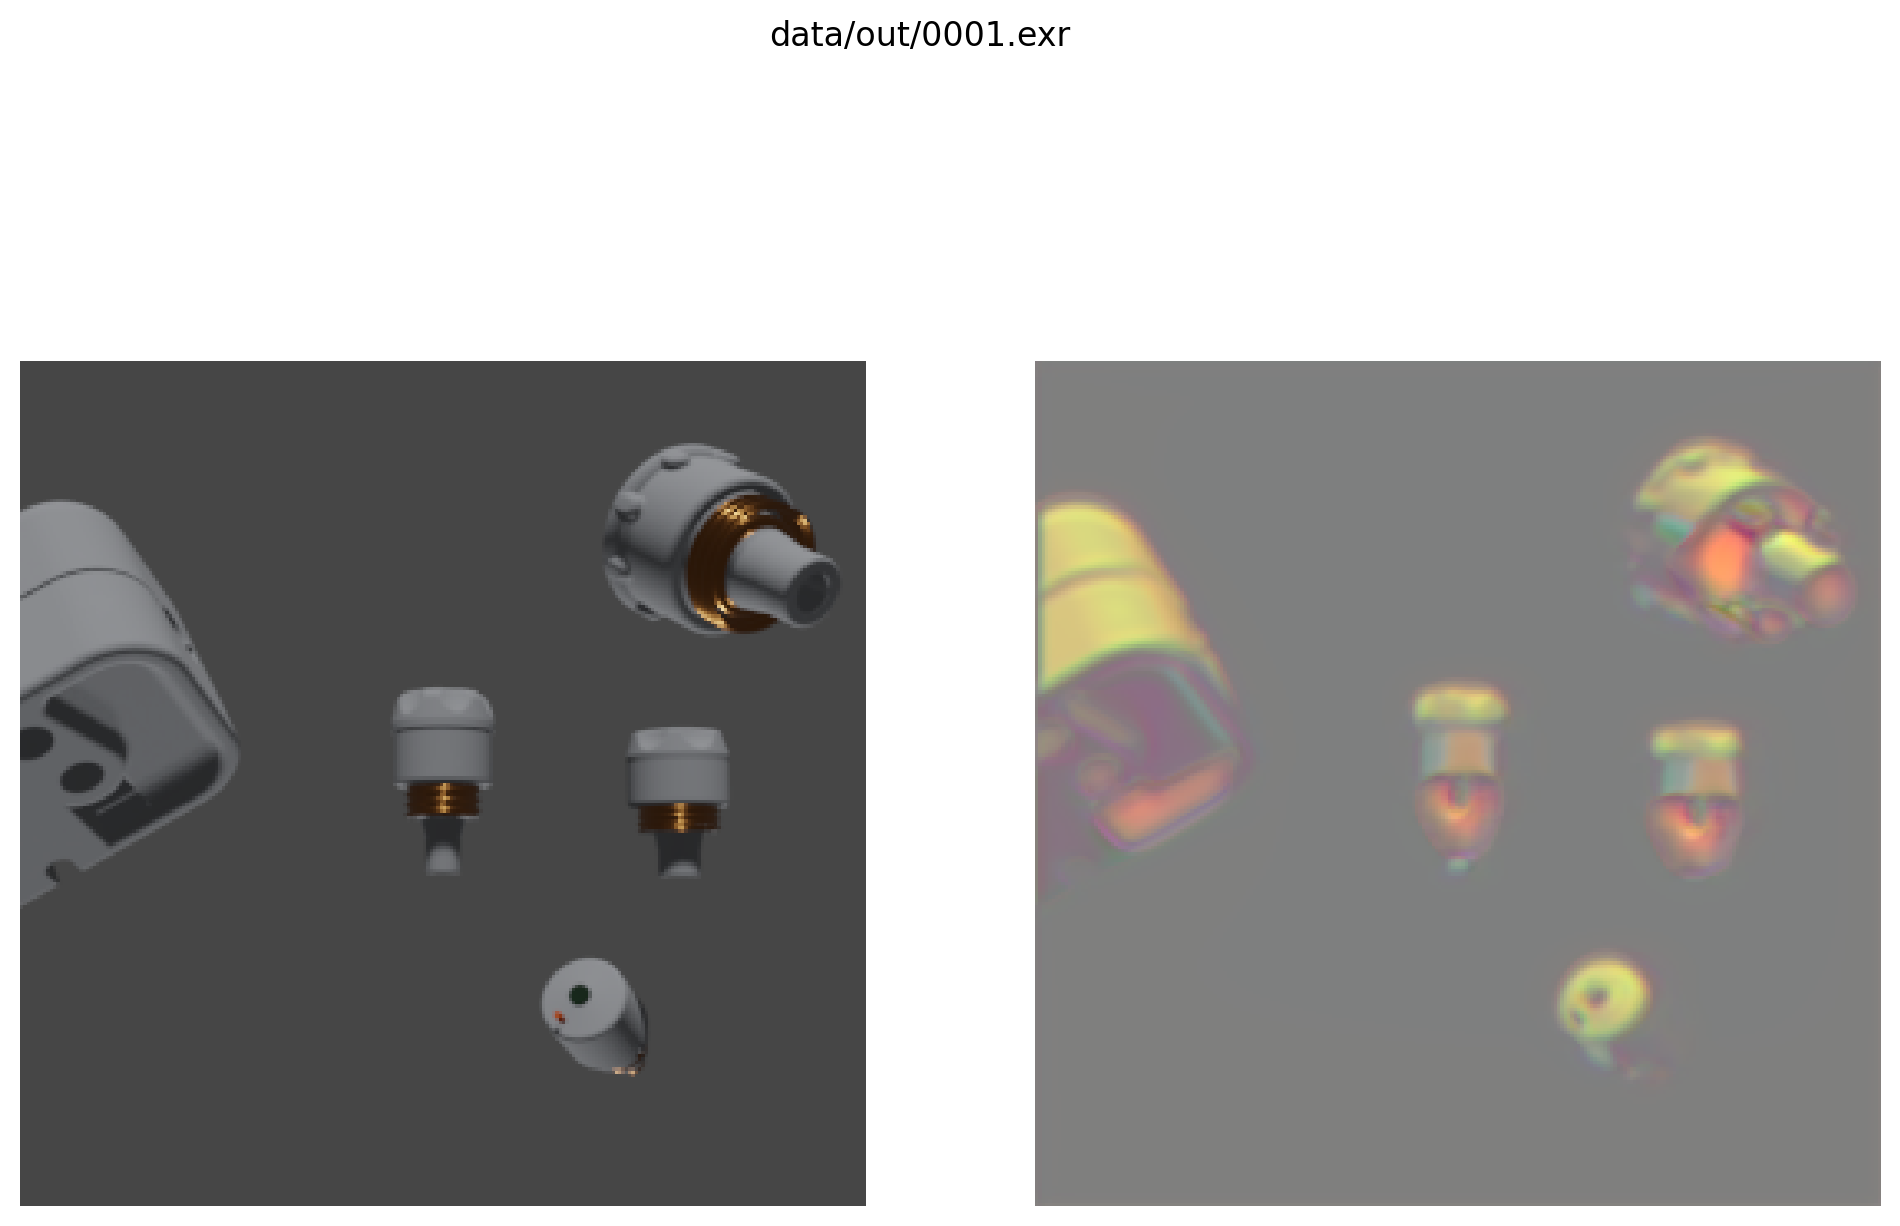

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])


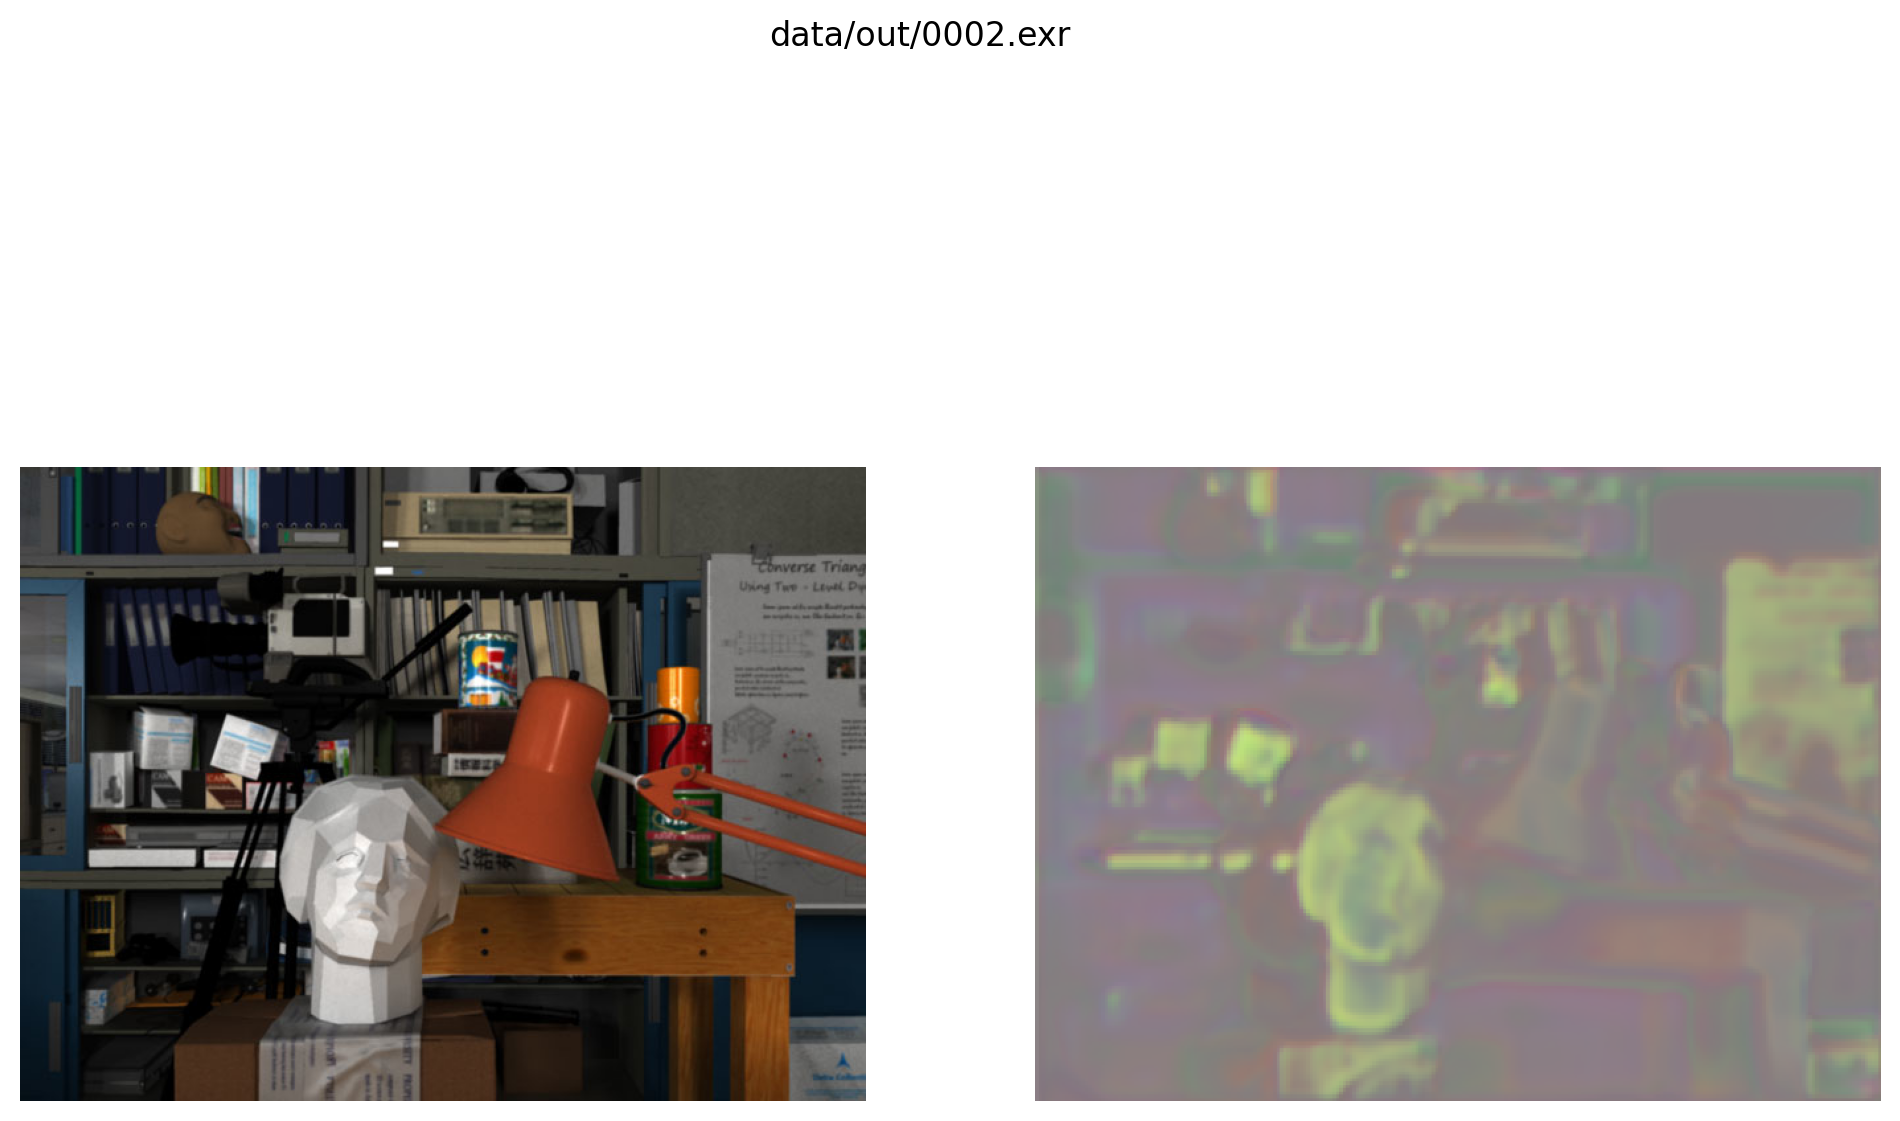

In [23]:
if LOAD_TEST_MODEL:
    epoch_idx, model = load_checkpoint(model, CHECKPOINT_TEST_FILE, DEVICE)

model.eval()
images = LoadImages(IMAGES, transform=detect_transform)
for img, predictions, path in generatePredictions(model, images):
    plot_predictions([img], predictions, [path])
    save_predictions([img], predictions, [path])

In [18]:
output_dir = os.path.join(OUT_PATH, re.sub("[^0-9a-zA-Z]+", "-", dt.now().isoformat()))

save_checkpoint(epoch_idx, model, output_dir)